In [ ]:
Dataset = https://drive.google.com/drive/folders/1t9y4OKeV78BBXxKEKrO0WjJhKtfr_QHC

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import torchvision.transforms as transforms
from PIL import  Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [4]:
# Dataset class
class DataMapper(Dataset):
    def __init__(self, dataset_directory):
        self.dataset_directory = dataset_directory

        self.cloud_directory = os.path.join(self.dataset_directory, "cloud/")
        self.image_file_cloud = os.listdir(self.cloud_directory)

        self.label_directory = os.path.join(self.dataset_directory, "label/")
        self.image_file_label = os.listdir(self.label_directory)

        self.transform = transforms.Compose(all_transforms)

    def __len__(self):
        return len(self.image_file_cloud)

    def __getitem__(self, item):
        cur_cloud_image_file = self.image_file_cloud[item]
        cur_label_image_file = self.image_file_label[item]

        cur_cloud_image_path = os.path.join(self.cloud_directory, cur_cloud_image_file)
        cur_label_image_path = os.path.join(self.label_directory, cur_label_image_file)

        cur_cloud_image = np.array(Image.open(cur_cloud_image_path))
        cur_label_image = np.array(Image.open(cur_label_image_path))

        cur_cloud_image = self.transform(cur_cloud_image)
        cur_label_image = self.transform(cur_label_image)

        return cur_cloud_image, cur_label_image

In [5]:
# UNet block
class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, is_downward=True, activation="relu", is_dropout=False):
        super().__init__()

        if is_downward:
            # Encoder
            if activation == "relu":
                self.convolution = nn.Sequential(
                    nn.Conv2d(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        kernel_size=4,
                        stride=2,
                        padding=1,
                        bias=False,
                        padding_mode="reflect"
                    ),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU()
                )
            else:
                self.convolution = nn.Sequential(
                    nn.Conv2d(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        kernel_size=4,
                        stride=2,
                        padding=1,
                        bias=False,
                        padding_mode="reflect"
                    ),
                    nn.BatchNorm2d(out_channels),
                    nn.LeakyReLU(0.2)
                )
        else:
            # Decoder
            if activation == "relu":
                self.convolution = nn.Sequential(
                    nn.ConvTranspose2d(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        kernel_size=4,
                        stride=2,
                        padding=1,
                        bias=False
                    ),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU()
                )
            else:
                self.convolution = nn.Sequential(
                    nn.ConvTranspose2d(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        kernel_size=4,
                        stride=2,
                        padding=1,
                        bias=False
                    ),
                    nn.BatchNorm2d(out_channels),
                    nn.LeakyReLU(0.2)
                )

        self.is_using_dropout = is_dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, _input):
        _input = self.convolution(_input)
        if self.is_using_dropout:
            return self.dropout(_input)
        else:
            return _input

In [6]:
# Generator
class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()

        self.first_downward = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=features,
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect"
            ),
            nn.LeakyReLU(0.2)
        )

        self.second_downward = UNetBlock(features, features * 2, is_downward=True, activation="leaky",
                                         is_dropout=False)
        self.third_downward = UNetBlock(features * 2, features * 4, is_downward=True, activation="leaky",
                                        is_dropout=False)
        self.four_downward = UNetBlock(features * 4, features * 8, is_downward=True, activation="leaky",
                                       is_dropout=False)
        self.five_downward = UNetBlock(features * 8, features * 8, is_downward=True, activation="leaky",
                                       is_dropout=False)
        self.six_downward = UNetBlock(features * 8, features * 8, is_downward=True, activation="leaky",
                                      is_dropout=False)
        self.seven_downward = UNetBlock(features * 8, features * 8, is_downward=True, activation="leaky",
                                        is_dropout=False)

        self.final_downward = nn.Sequential(
            nn.Conv2d(
                in_channels=features * 8,
                out_channels=features * 8,
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect"
            ),
            nn.ReLU()
        )

        self.first_upward = UNetBlock(features * 8, features * 8, is_downward=False, activation="relu",
                                      is_dropout=True)
        self.second_upward = UNetBlock(features * 8 * 2, features * 8, is_downward=False, activation="relu",
                                       is_dropout=True)
        self.third_upward = UNetBlock(features * 8 * 2, features * 8, is_downward=False, activation="relu",
                                      is_dropout=True)
        self.four_upward = UNetBlock(features * 8 * 2, features * 8, is_downward=False, activation="relu",
                                     is_dropout=False)
        self.five_upward = UNetBlock(features * 8 * 2, features * 4, is_downward=False, activation="relu",
                                     is_dropout=False)
        self.six_upward = UNetBlock(features * 4 * 2, features * 2, is_downward=False, activation="relu",
                                    is_dropout=False)
        self.seven_upward = UNetBlock(features * 2 * 2, features, is_downward=False, activation="relu",
                                      is_dropout=False)

        self.final_upward = nn.Sequential(
            nn.ConvTranspose2d(
                features * 2,
                in_channels,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.Tanh()
        )

    def forward(self, _input):
        downward_1 = self.first_downward(_input)
        downward_2 = self.second_downward(downward_1)
        downward_3 = self.third_downward(downward_2)
        downward_4 = self.four_downward(downward_3)
        downward_5 = self.five_downward(downward_4)
        downward_6 = self.six_downward(downward_5)
        downward_7 = self.seven_downward(downward_6)

        final = self.final_downward(downward_7)

        upward_1 = self.first_upward(final)
        upward_2 = self.second_upward(torch.cat([upward_1, downward_7], 1))
        upward_3 = self.third_upward(torch.cat([upward_2, downward_6], 1))
        upward_4 = self.four_upward(torch.cat([upward_3, downward_5], 1))
        upward_5 = self.five_upward(torch.cat([upward_4, downward_4], 1))
        upward_6 = self.six_upward(torch.cat([upward_5, downward_3], 1))
        upward_7 = self.seven_upward(torch.cat([upward_6, downward_2], 1))

        return self.final_upward(torch.cat([upward_7, downward_1], 1))

In [7]:
# Discriminator
class CNNLayer(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(CNNLayer, self).__init__()

        self.convolution = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=4,
                stride=stride,
                bias=False,
                padding_mode="reflect",
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, input_image):
        return self.convolution(input_image)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=None):
        super().__init__()

        if features is None:
            features = [64, 128, 256, 512]
        layers = []

        self.first = nn.Sequential(
            nn.Conv2d(
                in_channels * 2,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2),
        )

        in_channels = features[0]

        for cur_feature in features[1:]:
            if cur_feature != 512:
                layers.append(
                    CNNLayer(in_channels, cur_feature, stride=2),
                )
            else:
                layers.append(
                    CNNLayer(in_channels, cur_feature, stride=1),
                )
            in_channels = cur_feature

        layers.append(
            nn.Conv2d(
                in_channels,
                out_channels=1,
                kernel_size=4,
                stride=1,
                padding=1,
                padding_mode="reflect",
            ),
        )

        self.discriminator_model = nn.Sequential(*layers)

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.first(x)
        x = self.discriminator_model(x)
        return x

In [8]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Splitted RICE dataset into training and validation into 80:20 ratio
DIRECTORY_TRAINING = "/content/drive/MyDrive/RICE_train/"
DIRECTORY_VALIDATION = "/content/drive/MyDrive/RICE_validation/"

LEARNING_RATE = 2e-4
BATCH_SIZE = 16
COUNT_WORKERS = 2
IMAGE_SIZE = 256
IMAGE_CHANNELS = 3
L1_LAMBDA = 100
LAMBDA_GP = 10
BETA_ONE = 0.5
BETA_TWO = 0.999
NUM_EPOCHS = 500

FLAG_LOAD_MODEL = False
FLAG_SAVE_MODEL = True

CHECKPOINT_DISCRIMINATOR = "/content/drive/MyDrive/discriminator1.pth"
CHECKPOINT_GENERATOR = "/content/drive/MyDrive/generator1.pth"

# All transforms to be applied to the images
all_transforms = [transforms.ToPILImage(),
                  transforms.Resize((256, 256)),
                  transforms.ToTensor(),
                  transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
                  ]

# Training function
def start_training_dataset(discriminator, generator, train_dataloader, optimizer_discriminator,
                           optimizer_generator, loss_l1, loss_bce, scalar_generator, scalar_discriminator):
    loop = tqdm(train_dataloader, leave=True)

    for cur_index, (x, y) in enumerate(loop):
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        with torch.cuda.amp.autocast():
            y_fake = generator(x)
            discriminator_real = discriminator(x, y)
            discriminator_fake = discriminator(x, y_fake.detach())

            discriminator_real_loss = loss_bce(discriminator_real, torch.ones_like(discriminator_real, device=DEVICE))
            discriminator_fake_loss = loss_bce(discriminator_fake, torch.zeros_like(discriminator_fake, device=DEVICE))

            discriminator_total_loss = (discriminator_real_loss + discriminator_fake_loss) / 2

        discriminator.zero_grad()
        scalar_discriminator.scale(discriminator_total_loss).backward()
        scalar_discriminator.step(optimizer_discriminator)
        scalar_discriminator.update()

        with torch.cuda.amp.autocast():
            discriminator_fake = discriminator(x, y_fake)
            generator_fake_loss = loss_bce(discriminator_fake, torch.ones_like(discriminator_fake, device=DEVICE))
            generator_loss_l1 = loss_l1(y_fake, y) * L1_LAMBDA
            generator_total_loss = generator_fake_loss + generator_loss_l1

        optimizer_generator.zero_grad()
        scalar_generator.scale(generator_total_loss).backward()
        scalar_generator.step(optimizer_generator)
        scalar_generator.update()

        if cur_index % 10 == 0:
            loop.set_postfix(
                D_real=torch.sigmoid(discriminator_real).mean().item(),
                D_fake=torch.sigmoid(discriminator_fake).mean().item()
            )

# Main function
def main():
    discriminator = Discriminator(in_channels=3).to(DEVICE)
    generator = Generator(in_channels=3, features=64).to(DEVICE)

    optimizer_discriminator = optim.Adam(
        discriminator.parameters(),
        lr=LEARNING_RATE,
        betas=(BETA_ONE, BETA_TWO)
    )
    optimizer_generator = optim.Adam(
        generator.parameters(),
        lr=LEARNING_RATE,
        betas=(BETA_ONE, BETA_TWO)
    )

    loss_bce = nn.BCEWithLogitsLoss()
    loss_l1 = nn.L1Loss()

    train_dataset = DataMapper(DIRECTORY_TRAINING)
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=COUNT_WORKERS,
    )

    scalar_discriminator = torch.cuda.amp.GradScaler()
    scalar_generator = torch.cuda.amp.GradScaler()

    for cur_epoch in range(NUM_EPOCHS):
        start_training_dataset(
            discriminator, generator, train_dataloader, optimizer_discriminator,
            optimizer_generator, loss_l1, loss_bce, scalar_generator, scalar_discriminator,
        )

        if FLAG_SAVE_MODEL and cur_epoch % 5 == 0:
            torch.save(generator.state_dict(), CHECKPOINT_GENERATOR)
            torch.save(discriminator.state_dict(), CHECKPOINT_DISCRIMINATOR)

if __name__ == "__main__":
    main()



/usr/local/lib/python3.10/dist-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
  0%|          | 0/25 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
  0%|          | 0/25 [00:13<?, ?it/s]


KeyboardInterrupt: 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install scikit-image torchvision


PSNR value is 27.537898544363458 dB
SSIM value is 0.2733671248642245


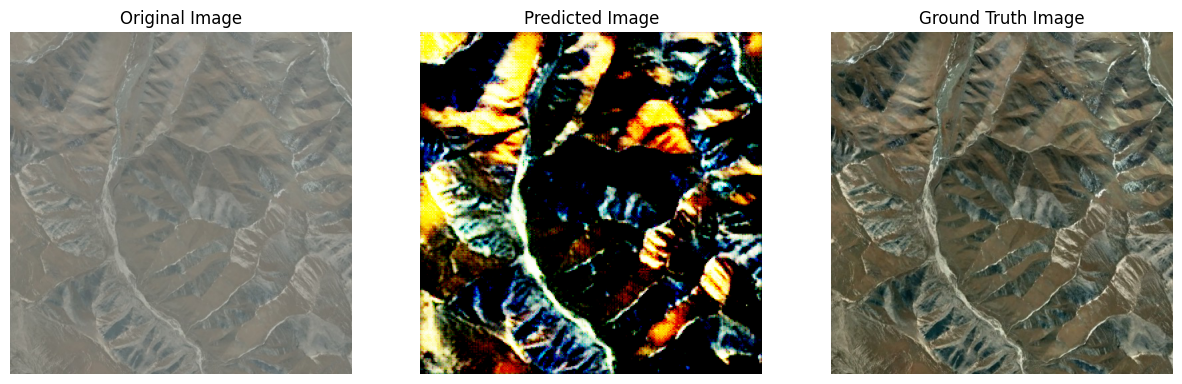

In [10]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as compare_ssim
import cv2
import math

# Load the state dictionary of the generator model
generator_state_dict = torch.load("/content/drive/MyDrive/generator.pth", map_location=torch.device('cpu'))

# Instantiate the Generator model and load the state dictionary
generator = Generator(in_channels=3, features=64)  # Instantiate the Generator model
generator.load_state_dict(generator_state_dict)

# Define the transformation to be applied to the input image
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

# Load and transform the test image
test_image = Image.open("/content/drive/MyDrive/testing_12.png")  # Replace "test_image.jpg" with the path to your test image
input_image = transform(test_image).unsqueeze(0)

# Generate the predicted image using the generator
with torch.no_grad():
    predicted_image = generator(input_image)

# Convert the predicted image to the range [0, 255] for each channel
predicted_image = (predicted_image * 255).clamp(0, 255).squeeze().permute(1, 2, 0).to(torch.uint8).cpu().numpy()

ground_truth_image = Image.open("/content/drive/MyDrive/testing_12cloudfree.png")  # Replace with the path to your ground truth image
ground_truth = cv2.imread("/content/drive/MyDrive/testing_12cloudfree.png")
resized_image = cv2.resize(ground_truth, (256,256))

predicted_gray = cv2.cvtColor(predicted_image, cv2.COLOR_BGR2GRAY)
ground_gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

predicted_normalized = cv2.normalize(predicted_gray, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
ground_normalized = cv2.normalize(ground_gray, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):
        return 100
    max_pixel = 255.0
    psnr = 20 * math.log10(max_pixel / math.sqrt(mse))
    return psnr

value = PSNR(predicted_normalized, ground_normalized)
print(f"PSNR value is {value} dB")

(score, _) = compare_ssim(predicted_normalized, ground_normalized, full=True)
print(f"SSIM value is {score}")

# Display the original image, ground truth image, and predicted image
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(test_image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(predicted_image, cmap='gray')
plt.title("Predicted Image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(ground_truth_image, cmap='gray')
plt.title("Ground Truth Image")
plt.axis('off')

plt.show()


PSNR: 27.67 dB
SSIM: 0.17


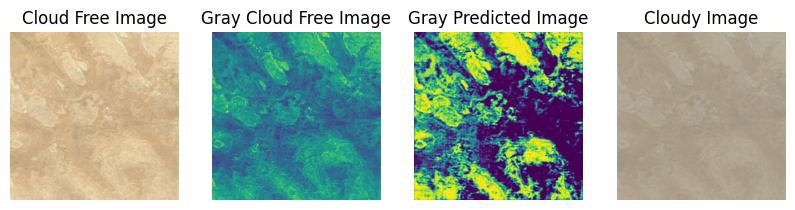

PSNR: 27.49 dB
SSIM: 0.07


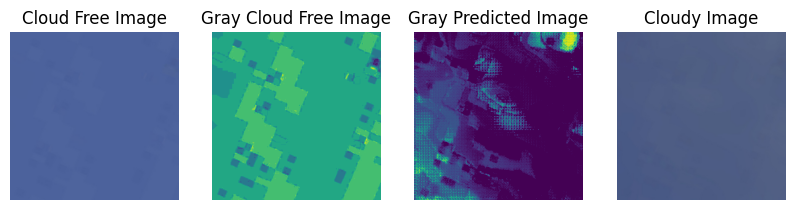

PSNR: 28.00 dB
SSIM: 0.25


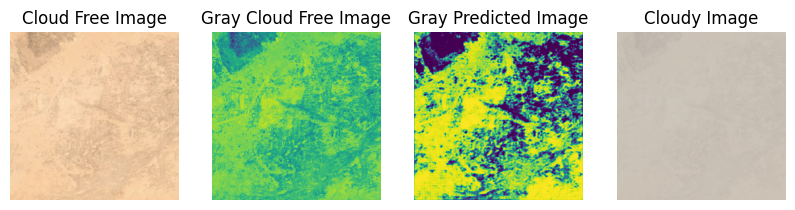

PSNR: 27.85 dB
SSIM: 0.26


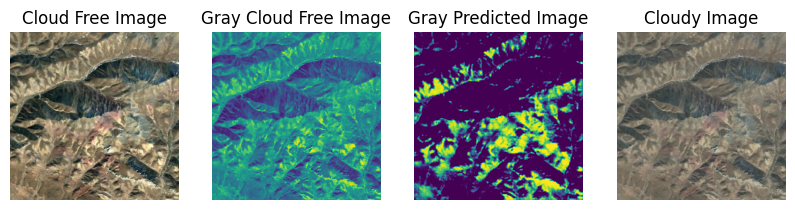

PSNR: 27.69 dB
SSIM: 0.33


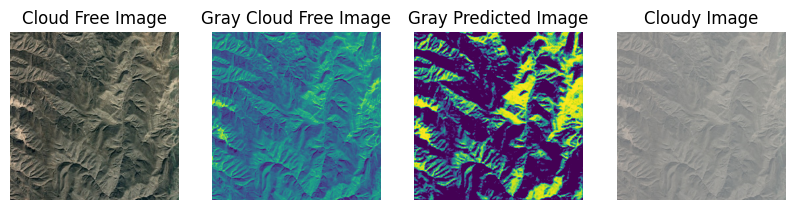

In [19]:
import random

# Directory settings
cloud_dir = "/content/drive/MyDrive/RICE1/cloud/"
label_dir = "/content/drive/MyDrive/RICE1/label/"

# Get a list of test images
test_images = os.listdir(cloud_dir)
random.shuffle(test_images)
test_images = test_images[:5]

# Processing images
for img_name in test_images:
# Load and transform cloud image
  cloud_image_path = os.path.join(cloud_dir, img_name)
  cloud_image = Image.open(cloud_image_path)
  input_image = transform(cloud_image).unsqueeze(0)
  # Generate the predicted image using the generator
  with torch.no_grad():
    predicted_image = generator(input_image)

  predicted_image = (predicted_image * 255).clamp(0, 255).squeeze().permute(1, 2, 0).to(torch.uint8).cpu().numpy()

  # Load ground truth image
  label_image_path = os.path.join(label_dir, img_name)
  ground_truth_image = Image.open(label_image_path)
  # Compute PSNR and SSIM
  predicted_gray = cv2.cvtColor(predicted_image, cv2.COLOR_BGR2GRAY)
  ground_truth_gray = cv2.imread(label_image_path, cv2.IMREAD_GRAYSCALE)
  ground_truth_resized = cv2.resize(ground_truth_gray, (256, 256)) # Ensure same size for SSIM and PSNR

  psnr_value = PSNR(ground_truth_resized, predicted_gray)
  score, _ = compare_ssim(predicted_gray, ground_truth_resized, full=True)

  print(f"PSNR: {psnr_value:.2f} dB\nSSIM: {score:.2f}")

  # Display results
  plt.figure(figsize=(10, 5))

  plt.subplot(1, 4, 1)
  plt.imshow(ground_truth_image)
  plt.title(f"Cloud Free Image")
  plt.axis('off')

  plt.subplot(1, 4, 2)
  plt.imshow(ground_truth_gray)
  plt.title(f"Gray Cloud Free Image")
  plt.axis('off')

  plt.subplot(1, 4, 3)
  plt.imshow(predicted_gray)
  plt.title("Gray Predicted Image")
  plt.axis('off')

  plt.subplot(1, 4, 4)
  plt.imshow(cloud_image)
  plt.title("Cloudy Image")
  plt.axis('off')



  plt.show()